In [1]:
!pip install numpy==1.23.1

In [2]:
!pip install gensim==3.8.3

In [2]:
!pip install scikit-learn==1.1.3

In [3]:
import pandas as pd
import numpy as np
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import pdfplumber
import regex as re
import matplotlib.pyplot as plt
import nltk
import requests
from io import BytesIO
import imblearn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet') 
import re
import contractions
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup 
pd.set_option('display.max_colwidth', None) 
import requests
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from gensim.models import Word2Vec
wv = api.load('word2vec-google-news-300')

C:\Users\yasmi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def read_file(file):
    with open(file) as user_file:
        file_contents = user_file.read()
        parsed_json = json.loads(file_contents)
        return parsed_json

In [5]:
def convert_to_dataframe(file1, file2):
    df1 = pd.DataFrame(file1)
    df2 = pd.DataFrame(file2)
    df = pd.concat([df1, df2],ignore_index=True)
    return df

In [6]:
data1 = read_file('extracted_neg_sentences_24th_report.json')
data2 = read_file('extracted_neg_sentences_31st_report.json')
df = convert_to_dataframe(data1, data2)

In [7]:
def remove_dates_titles_volume(sentence):
    sentence = sentence.replace('\n'," ")
    sentence = re.sub('[^\w\s]', '', sentence)
    sentence = re.sub('{January|February|March|April|May|June|July|August|September|October|November|December}', '', sentence)
    sentence = re.sub('\d', '', sentence)
    prefixes = "(Mr|St|Mrs|Ms|Dr|Ph.D|Chair|ViceChair|Volume)"
    sentence  = re.sub(prefixes, '', sentence)
    return sentence

def remove_stop_words(txt):
    stop = stopwords.words('english') 
    word_list = txt.split() 
    clean_list = []
    clean_string = ''
    for word in word_list:
        if word not in stop: 
            clean_list.append(word)
    clean_string = ' '.join(clean_list) 
    return clean_string

def contractionfunction(s):
    expanded_words = []
    for word in s.split():
        expanded_words.append(contractions.fix(word))
    result = ' '.join(expanded_words)
    return result

def remove_non_alphabetical(txt):
    regex = re.compile('[\W_0-9]+')
    dirty_list = txt.split()
    clean_list = [regex.sub(' ', word) for word in dirty_list] 
    clean_string = ' '.join(clean_list)
    return clean_string

def leammatize_review(txt): 
    lemmatizer = WordNetLemmatizer() 
    word_list = txt.split() 
    clean_list = []
    clean_string = ''
    for word in word_list:
        new_word = lemmatizer.lemmatize(word)
        clean_list.append(new_word) 
    clean_string = ' '.join(clean_list) 
    return clean_string

In [8]:
print(df.shape)
df.head()

(735, 4)


,sentence,page,label,confidence
0,DCPP acted prompt with corrective actions and submitted a Licensee Event Report when it discovered Technical Specification non-compliance on the Low Temperature Overpressure Protection System.,7,negative,0.917966
1,of power to Unit 2 4kV Bus G during Refueling Outage 2R17 was avoidable and was due to a number of breakdowns in the planning and conduct of a maintenance activity during the refueling outage.,8,negative,0.963733
2,"Three Station Level Human Performance Event Clock Resets occurred during the fourth quarter of 2013, causing the station’s 18-month indicator for such Resets to become Yellow (deficient).",8,negative,0.959724
3,Operations performance with respect to human error rate has been Red (Unsatisfactory) since July 2013.,8,negative,0.972823
4,The DCPP Fuel Handling System has been problematic since Refueling Outage 2R14 (March 2009).,9,negative,0.968485


In [9]:
# Applying preproccessing
df['sentence'] = df['sentence'].apply(lambda x:x.lower())
df['sentence'] = df['sentence'].apply(lambda body :remove_dates_titles_volume(body))
df['sentence'] = df['sentence'].apply(lambda body :contractionfunction(body))
df['sentence'] = df['sentence'].apply(lambda body :remove_non_alphabetical(body))
df['sentence'] = df['sentence'].apply(lambda review:remove_stop_words(review))
df['sentence'] = df['sentence'].apply(lambda txt :leammatize_review(txt))

In [10]:
df.head()

,sentence,page,label,confidence
0,dcpp acted prompt corrective action submitted licensee event report discovered technical specification noncompliance low temperature overpressure protection system,7,negative,0.917966
1,power unit kv bus g refueling outage r avoidable due number breakdown planning conduct maintenance activity refueling outage,8,negative,0.963733
2,three station level human performance event clock reset occurred fourth quarter causing station month indicator reset become yellow deficient,8,negative,0.959724
3,operation performance respect human error rate red unsatisfactory since july,8,negative,0.972823
4,dcpp fuel handling system problematic since refueling outage r march,9,negative,0.968485


In [11]:
# using google pretrained model where we take the average of the vector for each row of text
indexs = df['sentence'].index
df['google_word2vec'] = pd.Series(dtype=object)
for idx , texts in zip(indexs, df['sentence']):
    unseen_words = 0
    n = len(texts.split())
    x = 0
    for word in texts.split():
        try:
            x = x + wv[word]
        except KeyError:
            unseen_words = unseen_words + 1
    if unseen_words == n:
        df.at[idx, 'google_word2vec'] = np.NaN
        continue
    x = x/(n-unseen_words)
    x1 = x.reshape(-1, 1)
    x1 = x1.T
    df.at[idx, 'google_word2vec'] = x1[0]

In [12]:
df.head()

,sentence,page,label,confidence,google_word2vec
0,dcpp acted prompt corrective action submitted licensee event report discovered technical specification noncompliance low temperature overpressure protection system,7,negative,0.917966,"[-0.14205663, -0.021678252, 0.01987592, -0.012425142, -0.08965705, -0.056699865, 0.037886675, -0.07243796, 0.08315771, 0.02958769, -0.09407133, -0.089416504, 0.010616527, -0.011862362, -0.110136144, 0.06512451, -0.056540098, -0.018289005, -0.05487689, -0.09326172, 0.07113294, 0.054678526, -0.0803079, 0.022125917, 0.022933062, -0.12974997, -0.088228114, 0.043586284, 0.009794347, -0.04937385, -0.0911578, -0.16142543, 0.007632985, -0.07271082, -0.11177332, -0.1055888, 0.099049285, -0.0012278837, 0.05445772, -0.02891765, 0.08060949, 0.049732883, 0.04629337, -0.011460248, -0.094830684, -0.16598152, -0.057121724, -0.036032286, -0.14293446, 0.028788848, 0.047414444, -0.04794491, -0.027781768, -0.047298655, 0.07168338, 0.07113109, -0.019853929, -0.16050091, -0.016183292, -0.015086454, -0.047912598, 0.09712488, -0.114290126, -0.09879079, -0.08115881, -0.0024342258, -0.05411249, 0.114753276, -0.049794815, 0.011216108, 0.031910617, -0.11923128, 0.12102912, -0.0135031305, -0.11603142, -0.023223428, 0.099858455, -0.0022906135, 0.13338695, 0.055154238, 0.10759421, -0.009729722, -0.04011446, 0.023284463, 0.10158404, 0.027444279, -0.024292441, 0.096921586, -0.009909237, 0.033081055, 0.113338694, -0.0973403, -0.041500315, 0.05444336, 0.033928365, -0.032355815, -0.054299746, -0.019021427, 0.10159481, -0.022909725, ...]"
1,power unit kv bus g refueling outage r avoidable due number breakdown planning conduct maintenance activity refueling outage,8,negative,0.963733,"[-0.059929743, 0.073268995, 0.012613933, -0.028978135, -0.098361544, -0.054712933, -0.023773193, -0.16892157, 0.102138944, 0.099117704, 0.008890788, 0.054504395, -0.0861899, -0.0028118556, -0.050252277, 0.13847944, -0.034115262, -0.064961754, 0.04725043, -0.11694336, -0.02384101, -0.042226154, -0.06225035, 0.020287408, 0.020953707, 0.04599889, -0.1836887, 0.016282823, 0.04433865, -0.021769205, -0.009982639, -0.13826752, -0.05493164, -0.088005915, 0.009450276, -0.06278144, -0.094112396, -0.043056913, -0.0045844186, 0.060475666, -0.031134712, 0.0028008355, 0.081830345, 0.010677761, -0.06688372, -0.13127644, -0.095336914, 0.03201633, -0.10606554, 0.09323459, -0.0064247977, 0.02497779, 0.08406915, 0.088974, 0.013972812, -0.016480552, -0.08051215, 0.007405599, 0.028584799, -0.08199734, -0.071004234, 0.03999159, -0.0703108, -0.076444834, 0.007839627, -0.01570977, -0.21289995, 0.12391493, -0.106526695, 0.03266059, 0.047424316, -0.022162544, -0.0042961966, -0.03519694, -0.04378764, -0.08106147, -0.0015123156, -0.10692003, -0.031426325, -0.027696397, -0.006652832, 0.04988946, 0.061160617, 0.042812772, 0.05307346, -0.06782023, -0.0843366, 0.17333984, 0.040045843, 0.024615817, 0.10420736, -0.05388048, -0.028042264, 0.065331355, 0.02943251, -0.037502714, -0.08014933, -0.08425564, 0.03390927, 0.01449585, ...]"
2,three station level human performance event clock reset occurred fourth quarter causing station month indicator reset become yellow deficient,8,negative,0.959724,"[-0.052303918, 0.021878695, 0.066425525, 0.054301213, -0.08807052, -0.051256683, 0.08737665, -0.13914731, 0.1443385, 0.065892674, -0.0858604, -0.07470382, 0.038394324, -0.017208701, -0.033994976, 0.0507684, -0.029454282, -0.016209653, 0.023533871, -0.10980546, 0.014579372, -0.021738153, -0.07732833, -0.0066496194, 0.059064362, -0.021632144, -0.10916057, 0.12968686, 0.05580862, 0.06746633, -0.037010595, -0.12582879, -0.016635293, -0.09791324, -0.0017796566, -0.04927605, 0.0077803764, -0.046939246, 0.034504138, 0.051618475, 0.050357215, -0.0035978619, 0.07805593, 0.03626131, -0.0475239, -0.028731497, -0.01359799, 0.028893722, -0.035214074, 0.08479711, 0.009794536, -0.013385974, -0.014474969, -0.050735474, -0.04055786, 0.05522718, -0.05563957, -0.092164695, -0.0007324219, 0.034179688, -0.025159335, 0.

In [13]:
# get the vector_word2vec into a dataframe format 
vector_word2vec = np.array(df['google_word2vec'].values.tolist())
vector_word2vec
df_w2vec = pd.DataFrame(vector_word2vec, columns=[f"wv_{i}" for i in range(300)])
df_w2vec

,wv_0,wv_1,wv_2,wv_3,wv_4,wv_5,wv_6,wv_7,wv_8,wv_9,...,wv_290,wv_291,wv_292,wv_293,wv_294,wv_295,wv_296,wv_297,wv_298,wv_299
0,-0.142057,-0.021678,0.019876,-0.012425,-0.089657,-0.056700,0.037887,-0.072438,0.083158,0.029588,...,-0.014151,-0.040872,-0.056145,0.104787,-0.022865,0.053826,0.045719,-0.005561,0.000612,0.024525
1,-0.059930,0.073269,0.012614,-0.028978,-0.098362,-0.054713,-0.023773,-0.168922,0.102139,0.099118,...,0.007595,-0.019394,-0.021139,0.047979,-0.040480,-0.032569,-0.151428,0.081484,0.020684,-0.024536
2,-0.052304,0.021879,0.066426,0.054301,-0.088071,-0.051257,0.087377,-0.139147,0.144339,0.065893,...,0.036195,0.048044,-0.151592,-0.004324,-0.010068,-0.041130,-0.123220,-0.007254,0.045429,-0.025134
3,-0.016312,0.017322,0.115460,0.105591,-0.112170,-0.020984,0.104077,-0.194238,0.134619,0.164471,...,-0.067554,0.028409,-0.104858,0.021973,-0.042969,0.044263,-0.078970,-0.003461,-0.054535,0.040918
4,0.002965,0.160617,-0.045837,0.011637,-0.095228,-0.067112,-0.082574,-0.144002,0.040351,0.149848,...,-0.029582,-0.047672,-0.038601,0.113295,0.028639,-0.018636,-0.133002,0.006131,-0.001723,0.034844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,-0.010254,0.100066,-0.057963,-0.028296,-0.164307,0.079225,0.025248,-0.077087,0.173503,0.054810,...,-0.075302,0.085571,-0.058757,0.016724,-0.005046,0.084635,-0.010986,0.026693,-0.029338,-0.020793
731,-0.070676,0.059007,-0.040964,0.010263,-0.001606,-0.067453,-0.066669,-0.087384,0.147949,0.066920,...,0.025189,-0.063291,-0.060979,0.073491,-0.007330,-0.072472,-0.089581,-0.024165,0.041195,-0.008669
732,-0.039484,0.002657,-0.108731,-0.045011,-0.091414,-0.040108,0.039792,-0.135040,0.100941,0.076816,...,-0.011702,0.000871,-0.108862,-0.009782,-0.034180,-0.054427,-0.091264,-0.000533,0.030119,-0.028687
733,-0.119141,-0.003923,0.110657,0.036987,-0.078979,0.028870,-0.044205,-0.110229,0.265991,0.036316,...,0.059982,0.024384,-0.196167,0.113525,-0.114777,-0.020691,-0.112061,-0.042786,-0.025940,-0.012070


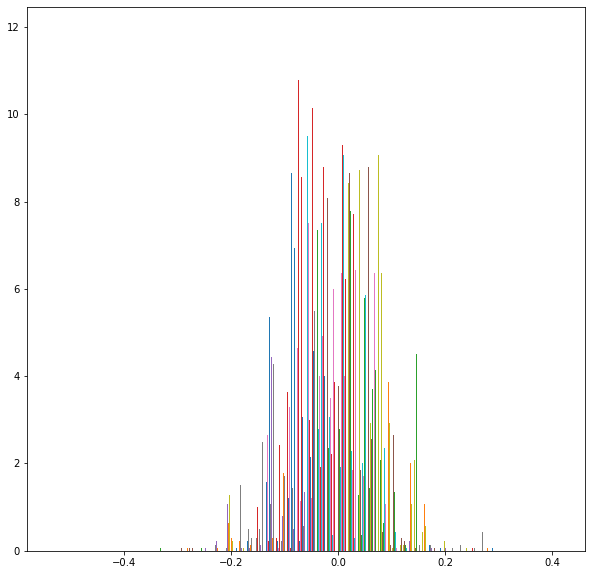

In [14]:
# Plot histogram of  word2vec to see distribution
from numpy import hstack
from matplotlib import pyplot as plt
plt.figure(figsize = (10,10))
plt.hist(vector_word2vec, bins=50, density=True)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.mixture import GaussianMixture

In [16]:
x_data = np.array(df_w2vec.values.tolist())
x_data
# make a hypothetical y-lable to be able to take advantage of train_test_split, and then we will oly use the x data
y = np.ones(735)
y.shape

(735,)

In [17]:
# split data into train, test
x_train, x_test, y_train, y_test = train_test_split(x_data, y, train_size = 0.8,
                                                                   test_size=0.2, random_state=200)

In [22]:
import os
os.environ["OMP_NUM_THREADS"] = '3'

In [87]:
gmm = GaussianMixture(n_components = 10, random_state=28)
gmm.fit(x_data)
y_pred = gmm.predict(x_data)

means = gmm.means_
cov_mat = gmm.covariances_
conv = gmm.n_iter_
print('The means = \n', means.shape)
print('The covariance matrices = \n', cov_mat.shape)
print('The convergence steps = \n', conv)

C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


The means = 
 (10, 300)
The covariance matrices = 
 (10, 300, 300)
The convergence steps = 
 3


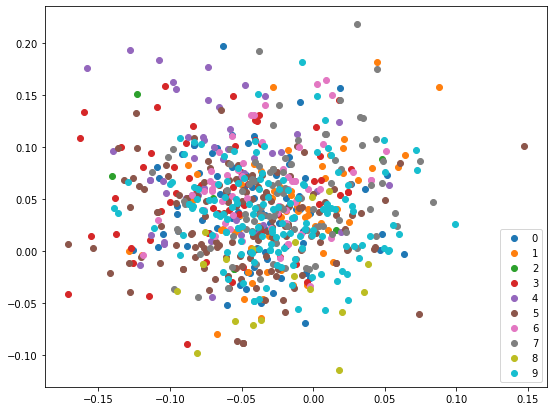

In [90]:
df = pd.DataFrame({'x':x_data[:,0], 'y':x_data[:,1], 'label':y_pred})
groups = df.groupby('label')

ig, ax = plt.subplots(figsize=(9,7))
for name, group in groups:
    ax.scatter(group.x, group.y, label=name)

ax.legend()
plt.show() 

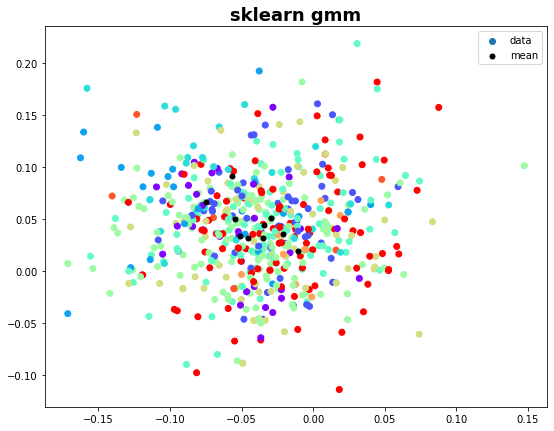

In [86]:
# visualize prediction
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(x_train[:, 0], x_train[:, 1], c = y_pred, label="data", cmap='rainbow')
# get centers for plot
means = gmm.means_
ax.scatter(means[:, 0], means[:, 1], c='black', label="mean", s=25 )
plt.title('sklearn gmm', fontsize=18, fontweight='demi')
plt.legend()
plt.show()

C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
<ipython-input-91-3792c611b4fc>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  f.add_subplot(2, 2, i-1)
C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\yasmi\anaconda3\lib\site-

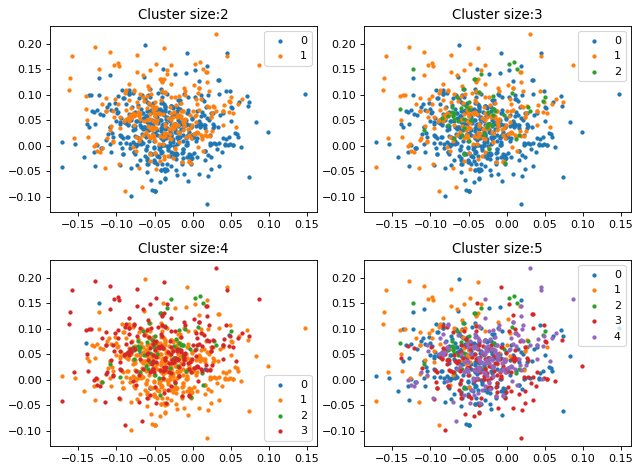

In [91]:
f = plt.figure(figsize=(8, 6), dpi=80)
f.add_subplot(2, 2, 1)

for i in range(2, 6):
    gm = GaussianMixture(n_components=i).fit(x_data)
    pred = gm.predict(x_data)
    df = pd.DataFrame({'x':x_data[:,0], 'y':x_data[:,1], 'label':pred})
    groups = df.groupby('label')
    f.add_subplot(2, 2, i-1)
    for name, group in groups:
        plt.scatter(group.x, group.y, label=name, s=8)
        plt.title("Cluster size:" + str(i))
        plt.legend()

plt.tight_layout()        
plt.show()  


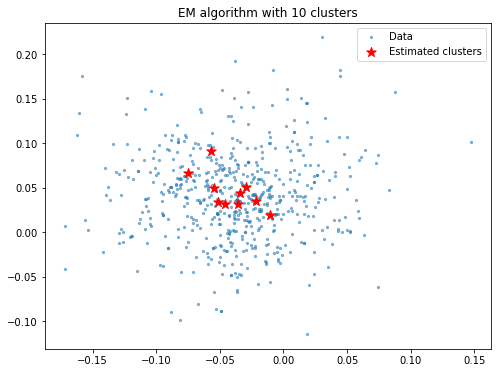

In [54]:
# Plot the data and the true and estimated clusters
plt.figure(figsize=(8, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], s=5, alpha=0.5)
plt.scatter(means[:, 0], means[:, 1], marker='*', c='r', s=100)
plt.title('EM algorithm with 10 clusters')
plt.legend(['Data', 'Estimated clusters'])
plt.show()


# KMEANS

In [33]:
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
centroid, label = kmeans2(x_data, 10, minit='points')
centroid

array([[-0.0343449 ,  0.04971375,  0.0086513 , ..., -0.01337129,
         0.00758562, -0.04377507],
       [-0.10766602,  0.07035208,  0.03483582, ..., -0.06324768,
         0.08769369,  0.10775757],
       [-0.15556641,  0.01407776,  0.05478515, ..., -0.04130859,
        -0.0059082 , -0.08076172],
       ...,
       [-0.0251694 ,  0.03052451,  0.01725503, ..., -0.01987958,
         0.00313509, -0.03759118],
       [-0.04002434,  0.066341  , -0.00808525, ...,  0.03849649,
         0.00552258, -0.01048075],
       [ 0.01105124,  0.04002441,  0.00835055, ..., -0.03296867,
         0.00267731, -0.03936428]])

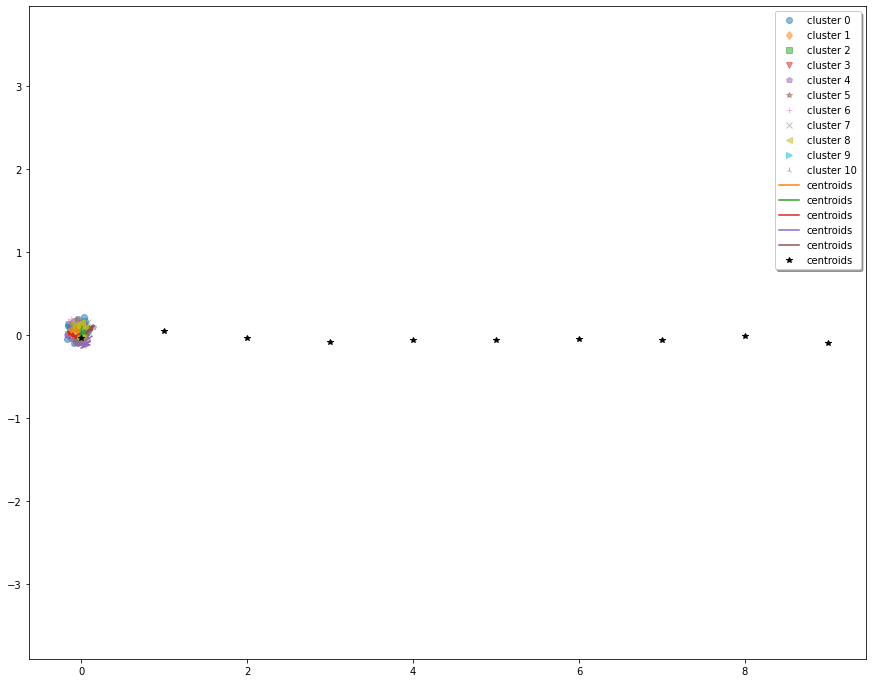

In [37]:
plt.figure(figsize=(15, 12))
w0 = x_data[label == 0]
w1 = x_data[label == 1]
w2 = x_data[label == 2]
w3 = x_data[label == 3]
w4 = x_data[label == 4]
w5 = x_data[label == 5]
w6 = x_data[label == 6]
w7 = x_data[label == 7]
w8 = x_data[label == 8]
w9 = x_data[label == 9]
w10 = x_data[label == 10]



plt.plot(w0[:, 0], w0[:, 1], 'o', alpha=0.5, label='cluster 0')
plt.plot(w1[:, 0], w1[:, 1], 'd', alpha=0.5, label='cluster 1')
plt.plot(w2[:, 0], w2[:, 1], 's', alpha=0.5, label='cluster 2')
plt.plot(w3[:, 0], w3[:, 1], 'v', alpha=0.5, label='cluster 3')
plt.plot(w4[:, 0], w4[:, 1], 'p', alpha=0.5, label='cluster 4')
plt.plot(w5[:, 0], w5[:, 1], '*', alpha=0.5, label='cluster 5')
plt.plot(w6[:, 0], w6[:, 1], '+', alpha=0.5, label='cluster 6')
plt.plot(w7[:, 0], w7[:, 1], 'x', alpha=0.5, label='cluster 7')
plt.plot(w8[:, 0], w8[:, 1], '<', alpha=0.5, label='cluster 8')
plt.plot(w9[:, 0], w9[:, 1], '>', alpha=0.5, label='cluster 9')
plt.plot(w10[:, 0], w10[:, 1], '2', alpha=0.5, label='cluster 10')



plt.plot(centroid[:, 0], centroid[:, 1], centroid[:, 2], centroid[:, 3], centroid[:, 4],
          centroid[:,5],  centroid[:, 6],  centroid[:, 7],  centroid[:, 8], 
          centroid[:, 9],  centroid[:, 10], 'k*', label='centroids')
plt.axis('equal')
plt.legend(shadow=True)
plt.show()

In [ ]:
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec

class LDA2Vec:
    def __init__(self, texts, num_topics, num_epochs):
        self.texts = texts
        self.num_topics = num_topics
        self.num_epochs = num_epochs
        self.model = None

    def fit(self):
        # Train word embeddings
        w2v = Word2Vec(
            sentences=self.texts,
            size=300,
            window=5,
            min_count=5,
            workers=4
        )

        # Train LDA model
        lda = LdaModel(
            corpus=[w2v.wv[t.text] for text in self.texts for t in text],
            id2word=w2v.wv,
            num_topics=self.num_topics
        )

        # Train LDA2Vec model
        self.model = Lda2Vec(
            sentences=self.texts,
            corpus=[lda[w2v.wv[t.text]] for text in self.texts for t in text],
            num
